In [1]:
from torchtext.utils import download_from_url, extract_archive
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import notebook

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import seaborn as sn

In [2]:
dataset_tar = download_from_url('https://drive.google.com/uc?id=1k7GfVRqrHFK00ABkit0oGQo62fCakMSZ', root='.data/')
extracted_files = extract_archive(dataset_tar)

In [3]:
from torch.utils.data import Dataset

class FAQDataset(Dataset):
    def __init__(self, faq_df, vectorizer):
        
        self.faq_df = faq_df
        self._vectorizer = vectorizer
        
        self.train_df = self.faq_df[self.faq_df.split == 'train']
        self.train_size = len(self.train_df)
        
        self.val_df = self.faq_df[self.faq_df.split == 'val']
        self.val_size = len(self.val_df)
        
        self.test_df = self.faq_df[self.faq_df.split == 'test']
        self.test_size = len(self.val_df)
        
        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'val': (self.val_df, self.val_size),
            'test': (self.test_df, self.test_size)
        }
        
        self.set_split('train')
        
        class_counts = faq_df.main_category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, faq_csv):
        faq_df = pd.read_csv(faq_csv, lineterminator='\n')
        train_faq_df = faq_df[faq_df.split=='train']
        return cls(faq_df, FAQVectorizer.from_dataframe(train_faq_df))
    
    def get_vectorizer(self):
        return self._vectorizer
    
    def set_split(self, split='train'):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        return self._target_size
    
    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        
        question_vector = self._vectorizer.vectorize(row.long_question)
        category_index = self._vectorizer.category_vocab.lookup_token(row.main_category)

        return {
            'x_data': question_vector,
            'y_target': category_index
        }
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)
    
def generate_batches(dataset, batch_size, shuffle = True, drop_last = True, device = "cpu"):
    dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = shuffle, drop_last = drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [4]:
class Vocabulary(object):
    
    def __init__(self, token_to_idx = None, add_unk = True, unk_token = "<UNK>"):
        
        if token_to_idx is None:
            token_to_idx = {}
        
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_inde = self.add_token(unk_token)

    def to_serializable(self):
        return {
            'token_to_idx': self._token_to_idx,
            'add_unk': self._add_unk,
            'unk_token': self._unk_token
        }
    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)
    
    def add_token(self, token):
        if token in self._token_to_idx:
            return self._token_to_idx[token]

        index = len(self._token_to_idx)
        
        self._token_to_idx[token] = index
        self._idx_to_token[index] = token
        
        return index
    
    def lookup_token(self, token):
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        return self._token_to_idx[token]
    
    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError(f"the index {index} is not in the Vocabulary")
        return self._idex_to_token[index]
    
    def __str__(self):
        return f"<Vocabulary(size={len(self)})>"
    
    def __len__(self):
        return len(self._token_to_idx)

In [5]:
from collections import Counter

class FAQVectorizer(object):
    
    def __init__(self, faq_vocab, category_vocab):
        self.faq_vocab = faq_vocab
        self.category_vocab = category_vocab
        
    def vectorize(self, faq):
        one_hot = np.zeros(len(self.faq_vocab), dtype=np.float32)
        
        for token in faq.split(" "):
            if token not in string.punctuation:
                one_hot[self.faq_vocab.lookup_token(token)] = 1
        
        return one_hot
    @classmethod
    def from_dataframe(cls, faq_df, cutoff = 25):
        faq_vocab = Vocabulary(add_unk = True)
        category_vocab = Vocabulary(add_unk = False)
        
        for category in set(faq_df.main_category):
            category_vocab.add_token(category)
            
        word_counts = Counter()
        
        for faq in faq_df.long_question:
            for word in faq.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
        for word, count in word_counts.items():
            if count > cutoff:
                faq_vocab.add_token(word)
                
        return cls(faq_vocab, category_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        faq_vocab = Vocabulary.from_serializable(contents['faq_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        
        return cls(faq_vocab = faq_vocab, category_vocab = category_vocab)
    
    def to_serializable(self):
        return {
            'faq_vocab': self.faq_vocab.to_serializable(),
            'category_vocab': self.category_vocab.to_serializable()
        }

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class FAQClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FAQClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax = False):
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [7]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        if loss_t >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1
        else:
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
            train_state['early_stopping_step'] = 0
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [8]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [9]:
from argparse import Namespace
import os
import torch
import numpy as np
import pandas as pd

In [10]:
args = Namespace(
    faq_csv = "data/faq_with_splits.csv",
    vectorizer_file = "vectorizer.json",
    model_state_file = "model.pth",
    save_dir = "model_storage/mlp",
    hidden_dim = 300,
    seed = 1234,
    num_epochs = 10,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    batch_size = 64,
    cuda = True,
    reload_from_files = False,
    expand_filepaths_to_save_dir = True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

set_seed_everywhere(args.seed, args.cuda)

handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/mlp/vectorizer.json
	model_storage/mlp/model.pth
Using CUDA: True


In [11]:
if args.reload_from_files:
    dataset = FAQDataset.load_dataset_and_load_vectorizer(args.faq_csv, args.vectorizer_file)
else:
    dataset = FAQDataset.load_dataset_and_make_vectorizer(args.faq_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()
classifier = FAQClassifier(input_dim = len(vectorizer.faq_vocab), 
                               hidden_dim = args.hidden_dim, 
                               output_dim = len(vectorizer.category_vocab))

In [12]:
def class_accuracy(preds, y):
    rounded_preds = preds.argmax(1)
    correct = (rounded_preds == y).float()

    acc = correct.sum() / len(correct)
    return acc

In [13]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = notebook.tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = class_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = class_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/10 [00:00<?, ?it/s]

split=train:   0%|          | 0/1838 [00:00<?, ?it/s]

split=val:   0%|          | 0/394 [00:00<?, ?it/s]

In [14]:
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

total_predicted = []
total_target = []

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'])
    
    total_predicted += y_pred.argmax(1).tolist()
    total_target += batch_dict['y_target'].tolist()
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = class_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [15]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.6515037020866948;
Test Accuracy: 0.9084311127662659


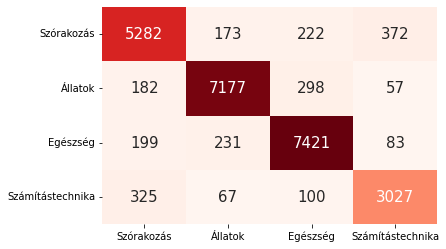

In [16]:
cm = confusion_matrix(total_target, total_predicted)
target_names = set(dataset.faq_df.main_category)
cm_df = pd.DataFrame(cm, index = target_names, columns = target_names)


heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)